In [57]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import rc, rcParams
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Parámetros a ajustar
ciudad = "Palma de Mallorca"
frecuencia = "Daily"
create_data_file = False
data_file = "PalmaMallorca.csv"
SEED = 1234

In [3]:
if create_data_file:
    # Obtenemos una lista de todos los archivos CSV de esa ciudad
    csv_files = []
    for file in os.listdir():
        if ".csv" in file:
            if ciudad in file and frecuencia in file:
                csv_files.append(file)

    # Ordenamos la lista
    csv_files.sort()

    # Fusionamos todos los ficheros CSV
    header_printed = False
    with open(data_file, "w") as fout:
        for file in csv_files:
            with open(file, "r") as f:
                line = f.readline()
                if not header_printed:
                    fout.write(line)
                    header_printed = True
                line = f.readline()
                while line != "":
                    fout.write(line)
                    line = f.readline()

In [4]:
data = pd.read_csv(data_file, sep=",")

In [5]:
useless_columns = ["icon", "stations", "description", "preciptype"]

# Eliminamos algunas columnas inútiles
for column in useless_columns:
    try:
        data = data.drop(column, axis=1)
    except KeyError:
        pass

# Desechamos las columnas con más de un cuarto de valores NaN
data = data.dropna(axis=1, thresh=0.75*len(data))

In [6]:
# Separamos las fechas en año, mes y día
data["year"] = data.apply(lambda row: int(row["datetime"].split("-")[0]), axis=1)
data["month"] = data.apply(lambda row: int(row["datetime"].split("-")[1]), axis=1)
data["day"] = data.apply(lambda row: int(row["datetime"].split("-")[2]), axis=1)
data = data.drop(["datetime"], axis=1)

In [7]:
numerical = data.drop(["name", "conditions"], axis=1)
categorical = data.filter(["conditions"])

In [8]:
for key in numerical:
    if numerical[key].isnull().values.any():
        numerical[key] = numerical[key].fillna(numerical[key].mean())

In [9]:
cat_num = pd.get_dummies(categorical)

In [10]:
x = pd.concat([numerical, cat_num], axis=1)

# Temperatura

In [44]:
## Plotting style
rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage[sc]{mathpazo}")
rc("font", size=24)
rcParams['figure.figsize'] = 8, 8

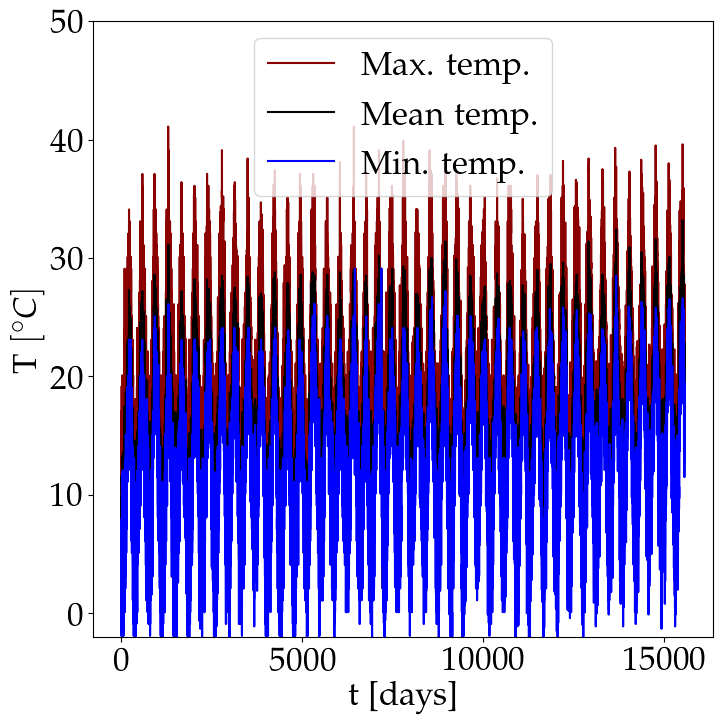

In [45]:
line1, = plt.plot(x["tempmax"], color="darkred", label=r"$\textnormal{Max. temp.}$")
line2, = plt.plot(x["temp"], color="black", label=r"$\textnormal{Mean temp.}$")
line3, = plt.plot(x["tempmin"], color="blue", label=r"$\textnormal{Min. temp.}$")
plt.xlabel(r"$\textnormal{t [days]}$")
plt.ylabel(r"$\textnormal{T }[^{\circ}C]$")
plt.ylim(-2, 50)
plt.legend(handles=[line1, line2, line3], loc="upper center")
plt.show()

In [11]:
first_year = min(data["year"])
last_year = max(data["year"]) - 1
years = [year for year in range(first_year, last_year+1)]

yearly_mean_t = np.zeros(last_year - first_year + 1)
yearly_std_t = np.zeros(last_year - first_year + 1)
yearly_mean_tmax = np.zeros(last_year - first_year + 1)
yearly_std_tmax = np.zeros(last_year - first_year + 1)
yearly_mean_tmin = np.zeros(last_year - first_year + 1)
yearly_std_tmin = np.zeros(last_year - first_year + 1)

for year in years:
    year_data = x[x["year"] == year]
    yearly_mean_t[year-first_year] = np.mean(year_data["temp"])
    yearly_std_t[year-first_year] = np.std(year_data["temp"])
    yearly_mean_tmax[year-first_year] = np.mean(year_data["tempmax"])
    yearly_std_tmax[year-first_year] = np.std(year_data["tempmax"])
    yearly_mean_tmin[year-first_year] = np.mean(year_data["tempmin"])
    yearly_std_tmin[year-first_year] = np.std(year_data["tempmin"])

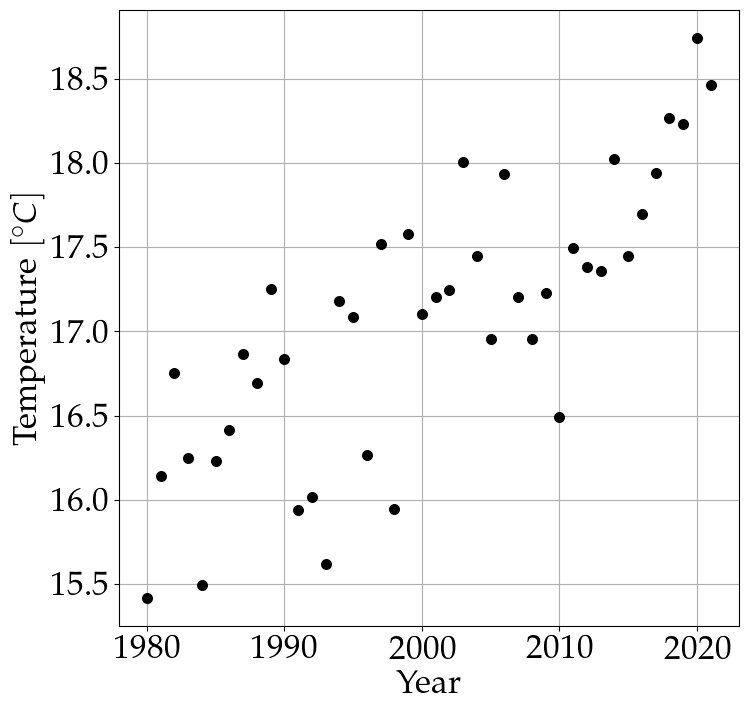

In [47]:
plt.scatter(years, yearly_mean_t, s=48, color="black", zorder=2)
#plt.errorbar(years, yearly_mean_t, yerr=yearly_std_t, fmt="o", color="black")
plt.xlabel(r"$\textnormal{Year}$")
plt.ylabel(r"$\textnormal{Temperature }[^{\circ}C]$")
plt.grid(zorder=1)
plt.savefig("AverageTempvsYears.pdf", dpi=150, bbox_inches="tight")
plt.show()

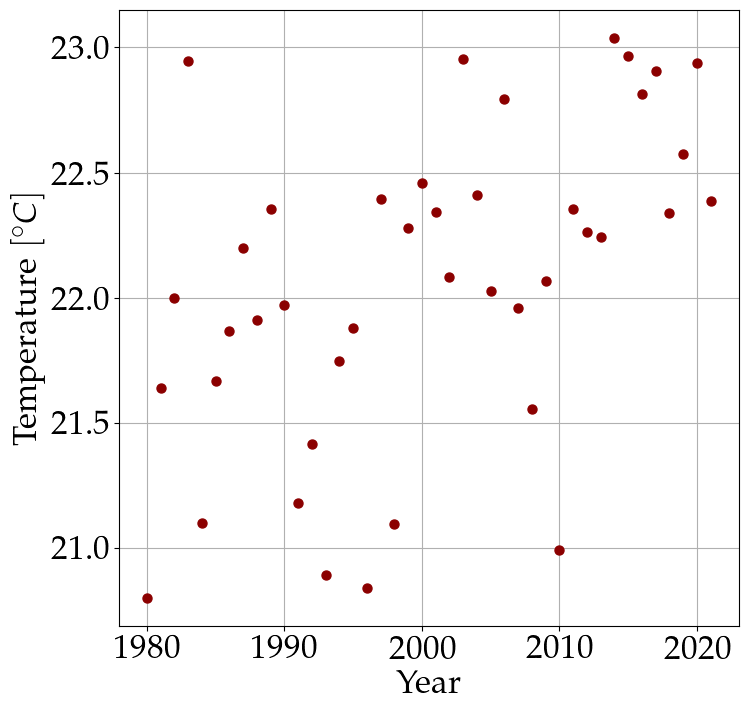

In [50]:
plt.scatter(years, yearly_mean_tmax, s=42, color="darkred", zorder=2)
#plt.errorbar(years, yearly_mean_t, yerr=yearly_std_tmax, fmt="o", color="darkred")
plt.xlabel(r"$\textnormal{Year}$")
plt.ylabel(r"$\textnormal{Temperature }[^{\circ}C]$")
plt.grid(zorder=1)
plt.savefig("AverageMaxTempvsYears.pdf", dpi=150, bbox_inches="tight")
plt.show()

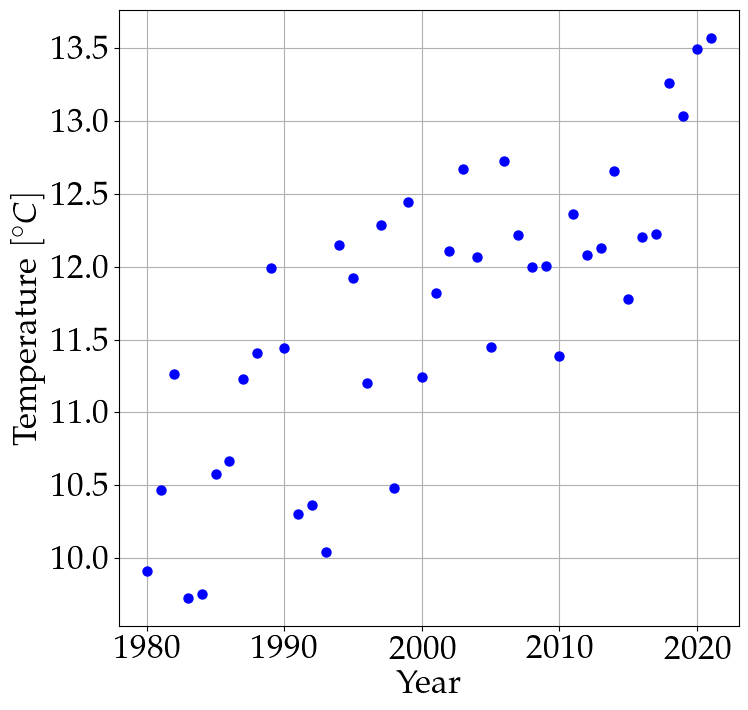

In [51]:
plt.scatter(years, yearly_mean_tmin, s=42, color="blue", zorder=2)
#plt.errorbar(years, yearly_mean_t, yerr=yearly_std_tmin, fmt="o", color="blue")
plt.xlabel(r"$\textnormal{Year}$")
plt.ylabel(r"$\textnormal{Temperature }[^{\circ}C]$")
plt.grid(zorder=1)
plt.savefig("AverageMinTempvsYears.pdf", dpi=150, bbox_inches="tight")
plt.show()

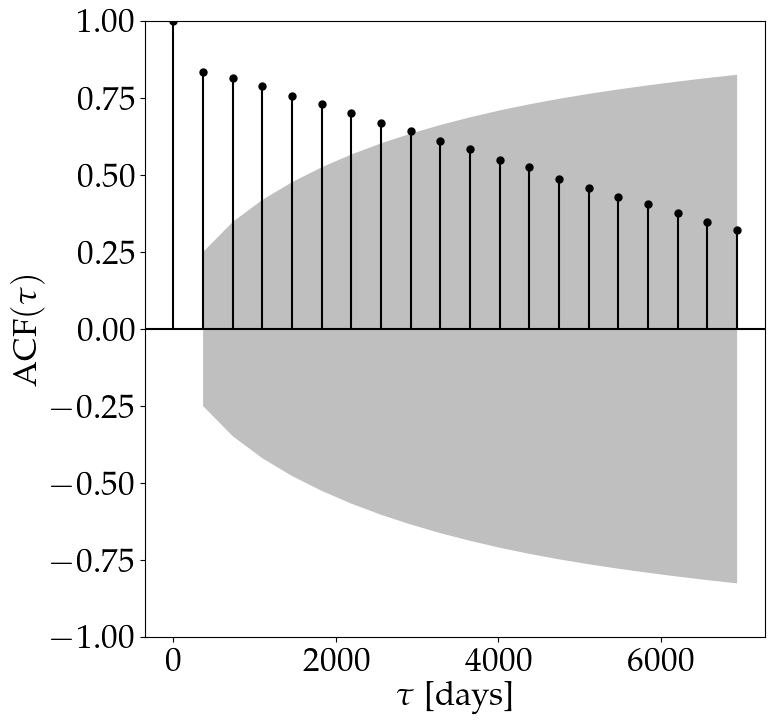

In [64]:
temp_color = "black"

fig, ax = plt.subplots()

plot_acf(x["temp"], lags=[365.2425*n for n in range((last_year-first_year)//2)],
         ax=ax, title="")

ax.set_xlabel(r"$\tau\textnormal{ [days]}$")
ax.set_ylabel(r"$\textnormal{ACF}(\tau)$")

for item in ax.collections:
    if type(item) == PolyCollection:
        item.set_facecolor(temp_color)
    elif type(item) == LineCollection:
        item.set_color(temp_color)

for item in ax.lines:
    item.set_color(temp_color)

plt.savefig("ACFMeanTemp.pdf", dpi=150, bbox_inches="tight")

plt.show()

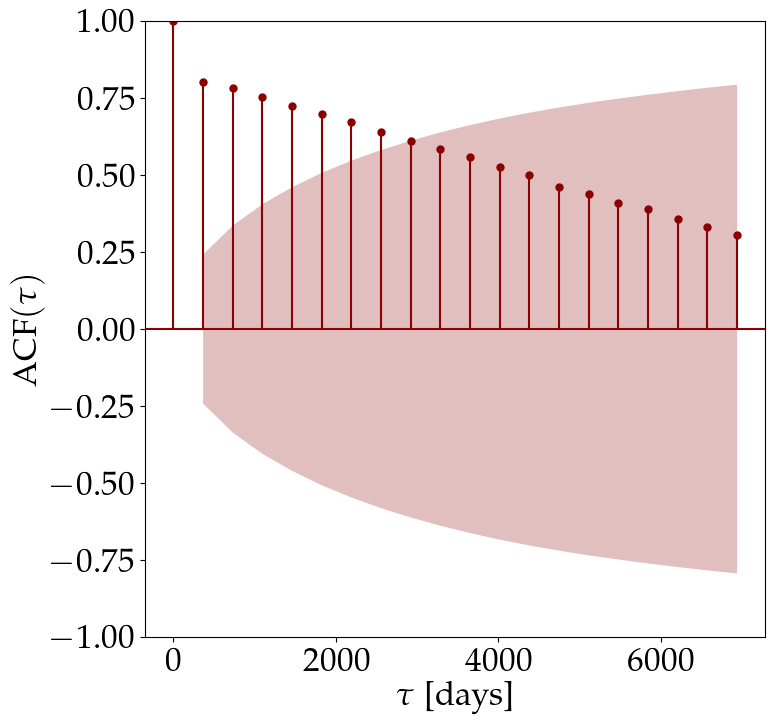

In [65]:
temp_color = "darkred"

fig, ax = plt.subplots()

plot_acf(x["tempmax"], lags=[365.2425*n for n in range((last_year-first_year)//2)],
         ax=ax, title="")

ax.set_xlabel(r"$\tau\textnormal{ [days]}$")
ax.set_ylabel(r"$\textnormal{ACF}(\tau)$")

for item in ax.collections:
    if type(item) == PolyCollection:
        item.set_facecolor(temp_color)
    elif type(item) == LineCollection:
        item.set_color(temp_color)

for item in ax.lines:
    item.set_color(temp_color)

plt.savefig("ACFMaxTemp.pdf", dpi=150, bbox_inches="tight")

plt.show()

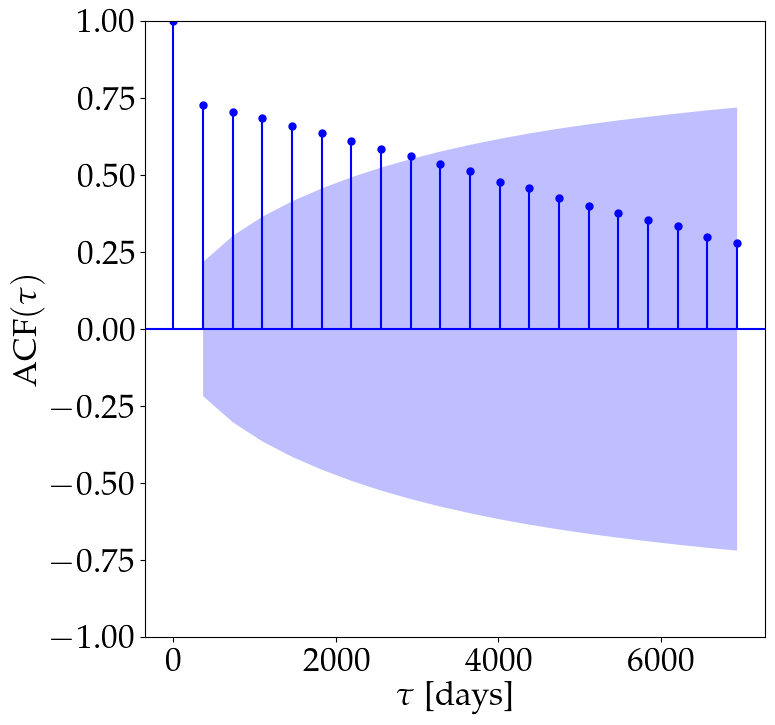

In [66]:
temp_color = "blue"

fig, ax = plt.subplots()

plot_acf(x["tempmin"], lags=[365.2425*n for n in range((last_year-first_year)//2)],
         ax=ax, title="")

ax.set_xlabel(r"$\tau\textnormal{ [days]}$")
ax.set_ylabel(r"$\textnormal{ACF}(\tau)$")

for item in ax.collections:
    if type(item) == PolyCollection:
        item.set_facecolor(temp_color)
    elif type(item) == LineCollection:
        item.set_color(temp_color)

for item in ax.lines:
    item.set_color(temp_color)

plt.savefig("ACFMinTemp.pdf", dpi=150, bbox_inches="tight")

plt.show()

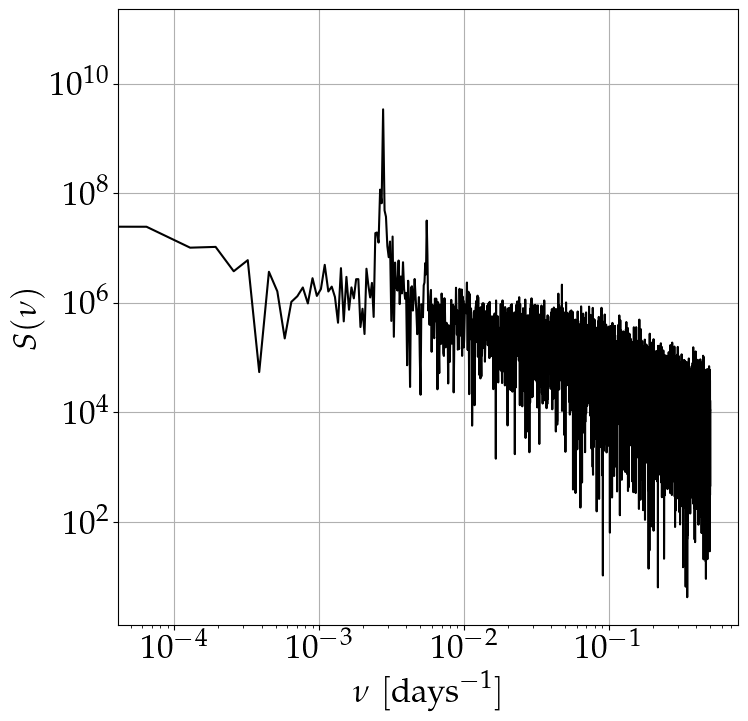

In [69]:
fourier_transform = np.fft.rfft(x["temp"])
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)

freqs = np.fft.rfftfreq(x["temp"].size, 1)
plt.plot(freqs, power_spectrum, color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\nu\ [\textnormal{days}^{-1}]$")
plt.ylabel(r"$S(\nu)$")
plt.grid()
plt.savefig("PSMeanTemp.pdf", dpi=150, bbox_inches="tight")
plt.show()

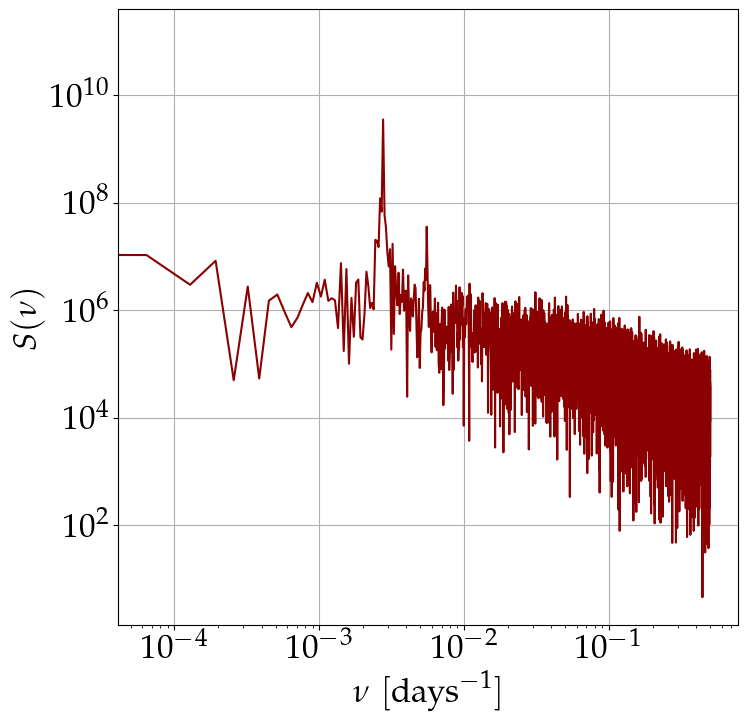

In [73]:
fourier_transform = np.fft.rfft(x["tempmax"])
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)

freqs = np.fft.rfftfreq(x["tempmax"].size, 1)
plt.plot(freqs, power_spectrum, color="darkred")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\nu\ [\textnormal{days}^{-1}]$")
plt.ylabel(r"$S(\nu)$")
plt.grid()
plt.savefig("PSMaxTemp.pdf", dpi=150, bbox_inches="tight")
plt.show()

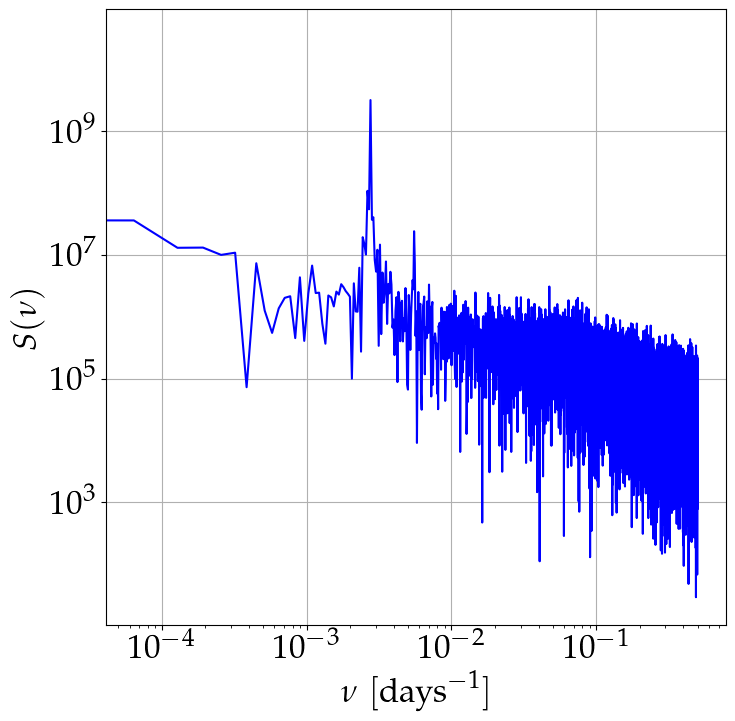

In [74]:
fourier_transform = np.fft.rfft(x["tempmin"])
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)

freqs = np.fft.rfftfreq(x["tempmin"].size, 1)
plt.plot(freqs, power_spectrum, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\nu\ [\textnormal{days}^{-1}]$")
plt.ylabel(r"$S(\nu)$")
plt.grid()
plt.savefig("PSMinTemp.pdf", dpi=150, bbox_inches="tight")
plt.show()